<a href='http://www.edu.upmc.fr/sdi/isi/fr/index.php/Accueil/M2_Syst%C3%A8mes_Intelligents_et_Robotique'><img src ='https://upload.wikimedia.org/wikipedia/fr/5/57/UPMC_Sorbonne_Universites.svg' width=500, align='center'></a>
<h1 align=center><font size = 5> tp images</font></h1>

<h1 align=droite><font size = 3> REALISE PAR:</font></h1>
<table border>
<tr1>
<td align='center'><b>Anis Chaarana</b></td><td align='center'><b>Pérel Degla</b></td><td align='center'><b>Hakim Heniche</b></td><td align='center'><b>Grace Lelo Loussongadio</b></td><td align='center'><b>Takieddine Soualhi</b></td>
</tr1>

<div align='right'>
<a href='#contact' class='btn btn-default' data-toggle='collapse'>Contacts</a>
</div>
<div id='contact' class='collapse'>
<img src ='https://i.imgur.com/LxfBIkN.gif' width = 1000, align ='centre'></a>
<table border>
<tr>
</tr>
</div>

# Objectif du Tp
Le but de ce tp est de 

# recherche bibléo

on profite du site que taki a trouver et de __l'article ci jointe__

# Importation

In [1]:
import cv2
import numpy as np
import glob
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv, norm , svd , qr
from PIL import Image
from matplotlib import pyplot as plt

# De vidéo a des images

In [ ]:
cap= cv2.VideoCapture('cam_video.avi') #changer l'adresse et le nom du vidéo
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('image'+str(i)+'.jpg',frame)
    i+=1
cap.release()
cv2.destroyAllWindows()

# Calibration des images

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

# 6x9 chess board, prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
object_point = np.zeros((6*9, 3), np.float32)
object_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# 3d point in real world space
object_points = []
# 2d points in image plane
image_points = []
h, w = 0, 0

images = glob.glob('images vision/*.jpg')
for file_name in images:
    image = cv2.imread(file_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape[:2]

    # find chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    #print(ret)
    # add object points, image points
    print(ret)
    if ret:
        object_points.append(object_point)
        cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        image_points.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        cv2.imshow('image', image)
        cv2.waitKey(500)

# calibration
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (w, h), None, None)

print ("camera matrix:\n", cameraMatrix)

# pi camera intrinsic parameters
ay = cameraMatrix[1, 1]
u0 = cameraMatrix[0, 2]
v0 = cameraMatrix[1, 2]
print ("Ay:", ay)
print ("u0:", u0)
print ("v0:", v0)

cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
camera matrix:
 [[1.10415137e+03 0.00000000e+00 6.43184423e+02]
 [0.00000000e+00 1.10636848e+03 3.57309821e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Ay: 1106.3684767902057
u0: 643.184422805137
v0: 357.30982110292274


# Rectification des images

In [4]:
#choisir des images pour rectification
ind1=0
ind2=14

R_mat_1,jacobian= cv2.Rodrigues(rvecs[ind1])
R_mat_2,jacobian= cv2.Rodrigues(rvecs[ind2])
T_vec_1=tvecs[ind1]
T_vec_2=tvecs[ind2]
P01=np.dot(cameraMatrix,np.concatenate((R_mat_1,T_vec_1),axis=1))
P02=np.dot(cameraMatrix,np.concatenate((R_mat_2,T_vec_2),axis=1))

In [5]:
def art(p):
    p=np.matrix(p)
    s=p[0:3,3]
    Q=inv(p[0:3,0:3])
    U,B=qr(Q)
    #fixé le signe de B(3,3)
    sig=np.sign(B[2,2])
    B=B*sig
    s=s*sig
    if B[0,0]<0:
        E=np.array([[-1,0,0],[0,1,0],[0,0,1]])
        B=E@B
        U=U@E
    if B[1,1]<0:
        E=np.array([[1,0,0],[0,-1,0],[0,0,1]])
        B=E@B
        U=U@E
    if np.linalg.det(U)<0:
        U=-U
        s=-s
    R=inv(U)
    t= B@s
    A=inv(B)
    A=A/A[2,2]
    return A,R,t

In [6]:
def rectif(po1,po2):
    #décomposition du matrice de projection
    A1,R1,t1=art(po1)
    A2,R2,t2=art(po2)
    #calcul de c1 et c2 
    C1=np.dot(-inv(po1[:,0:3]),po1[:,3])
    C2=np.dot(-inv(po2[:,0:3]),po2[:,3])
    #print("C1",C1)
    #nouveau axe x
    v1=C1-C2
    #nouveau axe y (orthogonal a x et ancient z)
    v2=np.cross(R1[2,:],v1)
    #nouveau z
    v3=np.cross(v1,v2)
    #normalisation
    v1=(np.matrix(v1/norm(v1))).T
    v2=(np.matrix(v2/norm(v2))).T
    v3=(np.matrix(v3/norm(v3))).T
    #nouveau extrainsic parametres
    R=np.concatenate((v1,v2,v3),axis=1)
    #new intrinsic parameters (arbitrary)
    #A=A1+A2/2
    #A[0,1]=0
    #nouveau matrice de projections
    P1=np.dot(A1,np.concatenate((R,-R@np.matrix(C1).T),axis=1))
    P2=np.dot(A2,np.concatenate((R,-R@np.matrix(C2).T),axis=1))
    #rectify image transformation
    T1=P1[0:3,0:3]@inv(po1[0:3,0:3])
    T2=P2[0:3,0:3]@inv(po2[0:3,0:3])
    return T1,T2,P1,P2

In [7]:
T1,T2,P1,P2=rectif(P01,P02)
print("T1=",T1)
print("T2=",T2)

T1= [[ 5.34852653e-01  9.02018256e-01 -1.29518331e+02]
 [-8.32771392e-01  4.56100469e-01  8.74248223e+02]
 [ 1.45032997e-04  1.70700529e-05  8.87531628e-01]]
T2= [[ 2.00214661e-01 -1.10113037e+00  5.80609939e+02]
 [ 9.31550536e-01  1.21286554e-01 -1.17373603e+02]
 [-8.87801918e-05 -2.70822757e-04  1.10287586e+00]]


# Affichage de la rectification avec opencv  

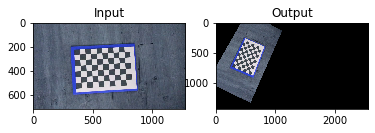

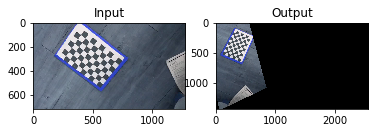

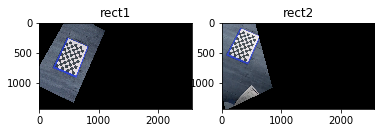

In [19]:
im_src1 = cv2.imread('images vision\output_00001.jpg')
im_out1 = cv2.warpPerspective(im_src1, T1, (im_src1.shape[1]*2,im_src1.shape[0]*2))
im_src2 = cv2.imread('images vision\output_00015.jpg')
im_out2 = cv2.warpPerspective(im_src2, T2, (im_src2.shape[1]*2,im_src2.shape[0]*2))

# Display images
plt.subplot(121),plt.imshow(im_src1),plt.title('Input')
plt.subplot(122),plt.imshow(im_out1),plt.title('Output')
plt.show()

plt.subplot(121),plt.imshow(im_src2),plt.title('Input')
plt.subplot(122),plt.imshow(im_out2),plt.title('Output')
plt.show()

plt.subplot(121),plt.imshow(im_out1),plt.title('rect1')
plt.subplot(122),plt.imshow(im_out2),plt.title('rect2')
plt.show()

# Fonction pour l'affichage des images rectifiées

In [26]:
def fix_image(img1,t1,img2,t2):
    new_image_map1 = {}
    minx1, miny1 = img1.shape[0], img1.shape[1]
    maxx1, maxy1 = 0, 0
    
    new_image_map2 = {}
    minx2, miny2 = img2.shape[0], img2.shape[1]
    maxx2, maxy2 = 0, 0
    
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            xy = np.array([i, j, 1], np.float64)
            uv = t1@xy
            uv = uv / uv.T[2]
            minx1 = min(minx1, uv.T[0])
            maxx1 = max(maxx1, uv.T[0])
            miny1 = min(miny1, uv.T[1])
            maxy1 = max(maxy1, uv.T[1])
            new_image_map1[int(uv.T[0]), int(uv.T[1])] = (i, j)

    minx1, miny1 = int(minx1), int(miny1)
    maxx1, maxy1 = int(maxx1), int(maxy1)
    
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
            xy = np.array([i, j, 1], np.float64)
            uv = t2@xy
            uv = uv / uv.T[2]
            minx2 = min(minx2, uv.T[0])
            maxx2 = max(maxx2, uv.T[0])
            miny2 = min(miny2, uv.T[1])
            maxy2 = max(maxy2, uv.T[1])
            new_image_map2[int(uv.T[0]), int(uv.T[1])] = (i, j)

    minx2, miny2 = int(minx2), int(miny2)
    maxx2, maxy2 = int(maxx2), int(maxy2)
    
    maxx=max(maxx1,maxx2)
    maxy=max(maxy1,maxy2)
    miny=min(miny1,miny2)
    minx=min(minx1,minx2)
    
    final_img1 = np.zeros((maxx - minx + 1, maxy - miny + 1, img1.shape[2]),dtype=np.int)
    final_img2 = np.zeros((maxx - minx + 1, maxy - miny + 1, img2.shape[2]),dtype=np.int)
    
    for k, v in new_image_map1.items():
        final_img1[k[0] - minx1, k[1] - miny1] = img1[v]
    for k, v in new_image_map2.items():
        final_img2[k[0] - minx2, k[1] - miny2] = img2[v]
        
    plt.subplot(121),plt.imshow(im_src1),plt.title('Input')
    plt.subplot(122),plt.imshow(final_img1),plt.title('Output')
    plt.show()

    plt.subplot(121),plt.imshow(im_src2),plt.title('Input')
    plt.subplot(122),plt.imshow(final_img2),plt.title('Output')
    plt.show()

    plt.subplot(121),plt.imshow(final_img1),plt.title('Input')
    plt.subplot(122),plt.imshow(final_img2),plt.title('Output')
    plt.show()
        

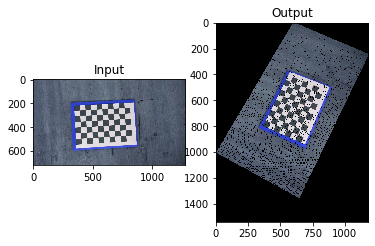

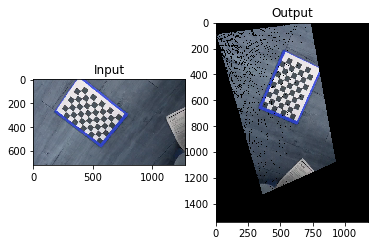

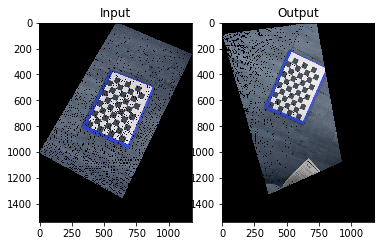

In [27]:
fix_image(im_src1, inv(T1),im_src2, inv(T2))